In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load the dataset from Kaggle URL
url = 'WHR2024.csv'
df = pd.read_csv(url)

# Inspect the data
print(df.head())

  Country name  Ladder score  upperwhisker  lowerwhisker  GDP per capita  \
0      Finland         7.741         7.815         7.667           1.844   
1      Denmark         7.583         7.665         7.500           1.908   
2      Iceland         7.525         7.618         7.433           1.881   
3       Sweden         7.344         7.422         7.267           1.878   
4       Israel         7.341         7.405         7.277           1.803   

   Social support  Healthy life expectancy  Freedom to make life choices  \
0           1.572                    0.695                         0.859   
1           1.520                    0.699                         0.823   
2           1.617                    0.718                         0.819   
3           1.501                    0.724                         0.838   
4           1.513                    0.740                         0.641   

   Generosity  Perceptions of corruption  Dystopia + residual  
0       0.142         

In [2]:
# Data Preprocessing
# Drop rows with missing values
df = df.dropna()

# Select features and target variable
X = df.drop(columns=['Country name', 'Ladder score', 'upperwhisker', 'lowerwhisker'])  # Drop unnecessary columns
y = df['Ladder score']  # Target variable (Ladder score)

# Standardize numerical features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Check if SMOTE is applicable, and only apply if there are imbalanced discrete classes
try:
    smote = SMOTE(sampling_strategy='auto', k_neighbors=2)
    X_resampled, y_resampled = smote.fit_resample(X, y)
except ValueError as e:
    print(f"SMOTE could not be applied: {e}")
    X_resampled, y_resampled = X, y  # Fallback to original data if SMOTE fails

# Split the resampled dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Data preprocessing completed.")

SMOTE could not be applied: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
Data preprocessing completed.


In [3]:
# Define regressors
regressors = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVM": SVR()
}

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}  # Store results for each regressor

for name, model in regressors.items():
    # Perform K-Fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    
    # Train the model on the full training set
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = r2  # Store R² score for later
    
    print(f"{name} Regressor:")
    print(f"  Cross-Validation MSE: {-cv_scores.mean():.4f}")
    print(f"  Test MSE: {mse:.4f}")
    print(f"  Test MAE: {mae:.4f}")
    print(f"  Test R^2: {r2:.4f}\n")

Random Forest Regressor:
  Cross-Validation MSE: 0.1681
  Test MSE: 0.1582
  Test MAE: 0.2742
  Test R^2: 0.8945

Gradient Boosting Regressor:
  Cross-Validation MSE: 0.0998
  Test MSE: 0.0862
  Test MAE: 0.2255
  Test R^2: 0.9425

SVM Regressor:
  Cross-Validation MSE: 0.1698
  Test MSE: 0.1047
  Test MAE: 0.1538
  Test R^2: 0.9301




Random Forest - Test Set Evaluation:
Mean Squared Error: 0.1582
R² Score: 0.8945


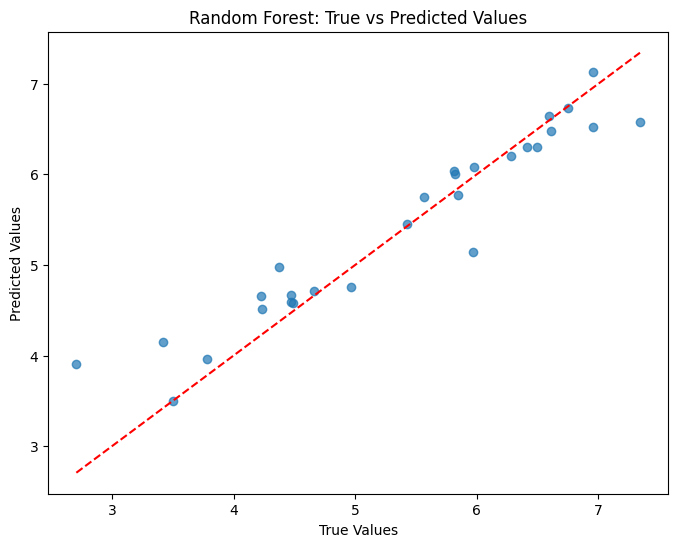


Gradient Boosting - Test Set Evaluation:
Mean Squared Error: 0.0862
R² Score: 0.9425


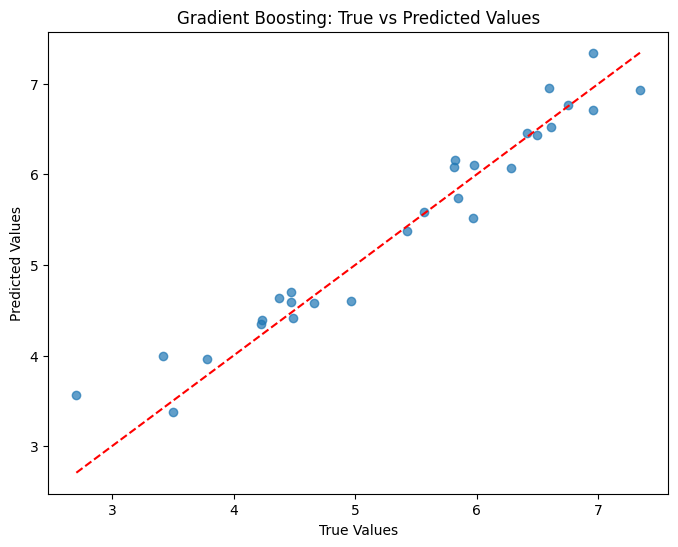


SVM - Test Set Evaluation:
Mean Squared Error: 0.1047
R² Score: 0.9301


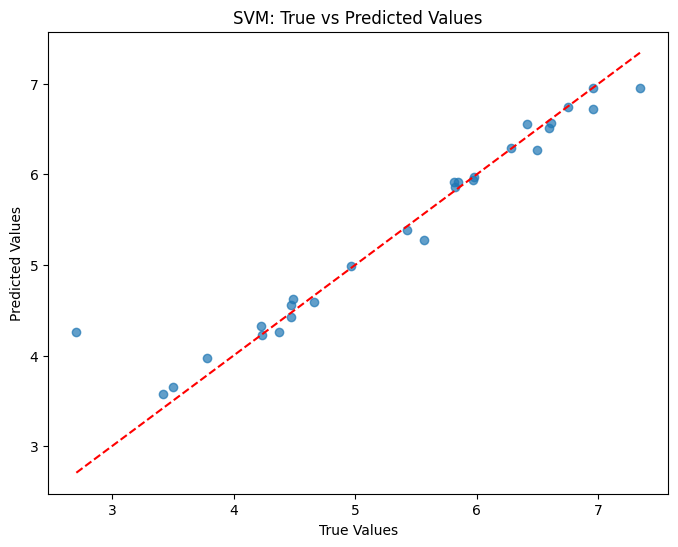

In [5]:
# Final evaluation on the test set
for regressor_name, regressor in regressors.items():
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    print(f"\n{regressor_name} - Test Set Evaluation:")
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')

    # Plotting true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(f'{regressor_name}: True vs Predicted Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

In [6]:
import joblib

joblib.dump(model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']